In [17]:
# Standard imports
import numpy as np
import pandas as pd
import json
import seaborn as sns
import matplotlib.pyplot as plt
from ieeg.auth import Session
from scipy import signal as sig
from scipy.integrate import simpson
from scipy.signal import coherence
from scipy.spatial.distance import pdist, squareform
from scipy.optimize import minimize

import scipy as sc
from bct.algorithms import community_louvain
plt.rcParams['image.cmap'] = 'BuPu'

# ML Imports
from sklearn.gaussian_process import GaussianProcessRegressor as GPR
from sklearn.gaussian_process.kernels import RBF,ConstantKernel
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import normalize
from sklearn.decomposition import NMF
from sklearn.utils import resample

# OS imports
import os
from os.path import join as ospj
from os.path import exists as ospe
import pathlib
from tqdm import tqdm
from utils import *
import sys
sys.path.append('/users/wojemann/iEEG_processing')
import mne

import os
os.environ["ETS_TOOLKIT"] = "qt4"
os.environ["QT_API"] = "pyqt5"

## Data Loading

In [18]:
metadata = pd.read_csv('../metadata_wchreject.csv')
# (metadata.cceps_hfs_seizure == 1) | 
metadata = metadata[(metadata.cceps_run1_sz == 1)].reset_index()
metadata.loc[:,'ieeg_id'] = 'HUP' + metadata.hupsubjno.apply(str) + '_phaseII'
metadata.loc[:,'ccep_id'] = 'HUP' + metadata.hupsubjno.apply(str) + '_CCEP'

In [19]:
with open('config.json','r') as f:
    CONFIG = json.load(f)
usr = CONFIG["paths"]["iEEG_USR"]
passpath = CONFIG["paths"]["iEEG_PWD"]
datapath = CONFIG["paths"]["RAW_DATA"]
prodatapath = CONFIG["paths"]["PROCESSED_DATA"]
ieeg_list = CONFIG["patients"]
rid_hup = pd.read_csv(ospj(datapath,'rid_hup.csv'))
pt_list = np.unique(np.array([i.split("_")[0] for i in ieeg_list]))

In [20]:
pt = "HUP235"
raw_datapath = ospj(datapath,pt)


In [21]:
dirty_drop_electrodes = metadata[metadata.hupsubjno == int(pt[-3:])]["final_reject_channels"].str.split(',').to_list()[0]
if isinstance(dirty_drop_electrodes,list):
        final_drop_electrodes = clean_labels(dirty_drop_electrodes,pt)
else:
    final_drop_electrodes = []

In [22]:
seizure_list = np.sort([s for s in os.listdir(ospj(raw_datapath, "seizures")) if 'preprocessed' in s])

In [23]:
all_seizures = []
all_ts = []
for seizure_path in seizure_list:
    seizure_fs = pd.read_pickle(ospj(raw_datapath,"seizures",seizure_path))
    fs = seizure_fs.fs.to_numpy()[-1]
    seizure = seizure_fs.drop("fs",axis=1)
    cols = seizure.columns.to_list()
    clean_ch = [c for c in cols if c not in final_drop_electrodes]
    seizure = seizure.loc[:,clean_ch]
    t = np.arange(0,len(seizure)/fs,1/fs)
    all_ts.append(t)
    all_seizures.append(seizure)
    # plot_iEEG_data(seizure,t)


### Electrode Agreement

In [24]:
hup_no = pt[3:]
rid = rid_hup[rid_hup.hupsubjno == hup_no].record_id.to_numpy()[0]
recon_path =  ospj('/mnt','leif','littlab','data',
                        'Human_Data','recon','BIDS_penn',
                        f'sub-RID0{rid}','derivatives','ieeg_recon',
                        'module3/')
atropos_metadata = pd.read_json(recon_path + f'sub-RID0{rid}_ses-clinical01_space-T00mri_atlas-atropos_radius-2_desc-vox_coordinates.json',lines=True)
atropos_metadata.loc[:,['name']] = clean_labels(atropos_metadata.name,pt)
localization_probs = pd.read_json(recon_path + f'sub-RID0{rid}_ses-clinical01_space-T00mri_atlas-DKTantspynet_radius-2_desc-vox_coordinates.json',lines=True)
localization_probs.loc[:,['name']] = clean_labels(localization_probs.name,pt)



In [25]:
def _apply_function(x):
    # look in labels sorted and see if it contains gray matter
    # if gray matter is greater than 5% then set label to gray matter
    x = pd.DataFrame(x).transpose()
    for i,label in enumerate(x['labels_sorted'].to_numpy()[0]):
        if (label != 'EmptyLabel') and (x['percent_assigned'].to_numpy()[0][i] > 0.05):
            x['label'] = label
            continue
        elif (label == 'white matter') and (x['percent_assigned'].to_numpy()[0][i] > 0.05):
            x['label'] = label
    return x

modified_regions = localization_probs.apply(_apply_function,axis=1)
modified_regions_df = pd.DataFrame(np.squeeze(np.array(modified_regions.to_list())),columns=localization_probs.columns)


In [35]:
modified_regions_df.loc[10:25]

,name,x,y,z,index,label,labels_sorted,percent_assigned
10,LA11,22.7031,137.657,131.043,0,left middle temporal,"[EmptyLabel, left middle temporal ]","[0.5757575758, 0.4242424242]"
11,LA12,17.0517,137.965,131.18,0,EmptyLabel,[EmptyLabel],[1.0]
12,LB01,74.4941,127.331,134.158,17,left hippocampus,"[ left hippocampus , EmptyLabel]","[0.7575757576000001, 0.24242424240000002]"
13,LB02,69.4456,126.925,135.293,17,left hippocampus,[ left hippocampus ],[1.0]
14,LB03,63.8108,127.048,136.527,17,left hippocampus,[ left hippocampus ],[1.0]
15,LB04,58.1594,127.357,136.664,0,EmptyLabel,"[EmptyLabel, left hippocampus ]","[0.9696969697000001, 0.030303030300000002]"
16,LB05,52.5481,126.926,137.804,0,EmptyLabel,[EmptyLabel],[1.0]
17,LB06,47.4761,127.074,139.034,0,EmptyLabel,[EmptyLabel],[1.0]
18,LB07,41.8482,126.828,139.077,0,left middle temporal,"[EmptyLabel, left superior temporal , left m...","[0.48484848480000003, 0.2727272727, 0.24242424..."
19,LB08,36.2134,126.952,140.311,1015,left middle temporal,"[ left middle temporal , EmptyLabel]","[0.8484848485, 0.1515151515]"


In [30]:
soz_ch = clean_labels(['LC1','LC2'],pt)
lf_soz_ch = clean_labels(['LI1', 'LI2', 'LA1', 'LA2', 'LB1', 'LB2', 'LB3', 'LB4', 'LC1', 'LC2', 'LC3'],pt)
hf_soz_ch = clean_labels(['LB1','LB2','LB3'],pt)

In [38]:
soz_array = modified_regions_df.name.isin(soz_ch).to_numpy()
lf_soz_array = modified_regions_df.name.isin(stim_soz_ch).to_numpy()
hf_soz_array = modified_regions_df.name.isin(hf_soz_ch).to_numpy()

In [54]:
all_regions = modified_regions_df['label'].unique()
clean_regions = [r for r in all_regions if r != 'EmptyLabel']
soz_region_labels = modified_regions_df.loc[modified_regions_df.name.isin(soz_ch),['label']].to_array()
soz_region_array = [r in soz_region_labels for r in clean_regions]
soz_region_array

[' left amygdala ', ' left middle temporal ', ' left hippocampus ', ' left fusiform ', ' left superior temporal ', ' left insula ', ' left pars opercularis ', ' left precentral ', ' left thalamus proper ', ' left pallidium ', ' left putamen ', ' left transverse temporal ', ' left caudal anterior cingulate ', ' left rostral middle frontal ', ' left posterior cingulate ']


AttributeError: 'DataFrame' object has no attribute 'to_list'

### Convex Hulls

In [12]:
soz_coords = atropos_metadata.loc[atropos_metadata.name.isin(soz_ch),['x','y','z']]
soz_coords

lf_coords = atropos_metadata.loc[atropos_metadata.name.isin(lf_soz_ch),['x','y','z']]

hf_soz_coords = atropos_metadata.loc[atropos_metadata.name.isin(soz_ch),['x','y','z']]
hf_soz_coords

,x,y,z
24,67.2158,113.871,137.636


In [11]:
lf_hull = sc.spatial.ConvexHull(lf_coords)
lf_dhull = sc.spatial.Delaunay(lf_coords)
lf_intersect = lf_dhull.find_simplex(soz_coords) >=0

137.636


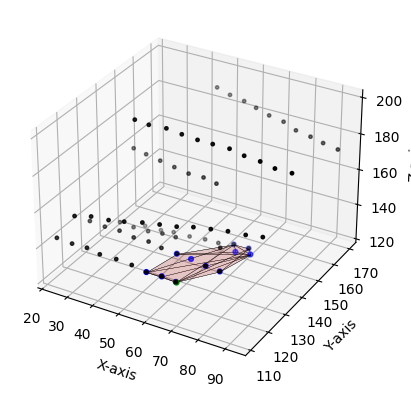

In [12]:
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
points = lf_coords.to_numpy()

# Plot all electrodes
all_contacts = atropos_metadata.loc[atropos_metadata.name.isin(clean_ch),['x','y','z']].to_numpy()
ax.scatter(all_contacts[:,0],all_contacts[:,1],all_contacts[:,2],"o",color="k",s=6)

# Plot the points
ax.scatter(points[:, 0], points[:, 1], points[:, 2], "o", color="b", s=12)

# Plot the convex hull's facets
for simplex in lf_hull.simplices:
    polygon = [lf_hull.points[i] for i in simplex]
    poly3d = [[vert[ix] for vert in polygon] for ix in range(3)]
    ax.plot_trisurf(*poly3d, color='r',edgecolor='k',linewidth=.2, alpha=0.1)
coords = soz_coords.to_numpy()[0]
print(coords[2])
ax.scatter(coords[0],coords[1],coords[2],"o",color='g',s=12)

ax.set_xlabel("X-axis")
ax.set_ylabel("Y-axis")
ax.set_zlabel("Z-axis")
plt.show()

In [12]:
# import numpy as np
# from scipy.spatial import ConvexHull
# from nilearn import datasets, surface
# from mayavi import mlab
# # mlab.options.offscreen = True
# # Fetch the fsaverage dataset
# fsaverage = datasets.fetch_surf_fsaverage(mesh='fsaverage')

# # Load the coordinates (vertices) and triangles (faces) from the mesh files
# coords, faces = surface.load_surf_mesh(fsaverage.pial_left)

# # Display the brain's surface
# mlab.triangular_mesh(coords[:, 0], coords[:, 1], coords[:, 2], faces, color=(0.5, 0.5, 0.5), opacity=0.6)

# # Generate random data points for the convex hull
# points = np.random.rand(30, 3) * 200 - 100  # Adjust these values as needed to position on the brain surface

# # Compute the convex hull of the points
# hull = ConvexHull(points)

# # Plot the convex hull's simplices (triangular facets) on top of the brain surface
# mlab.triangular_mesh(points[:, 0], points[:, 1], points[:, 2], hull.simplices, color=(1, 0, 0))

# # Display the visualization
# # mlab.show()

# img = mlab.screenshot()
# plt.imshow(img)
# plt.axis('off')
# plt.show()
